In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from generate_network_nodes import generate_network
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant, ArrayOutcome
import time

df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))

There were 5 nodes added, the longest remaining link is now: 48533.206009320114
5 intersections were added
CPU times: total: 1.62 s
Wall time: 5.67 s


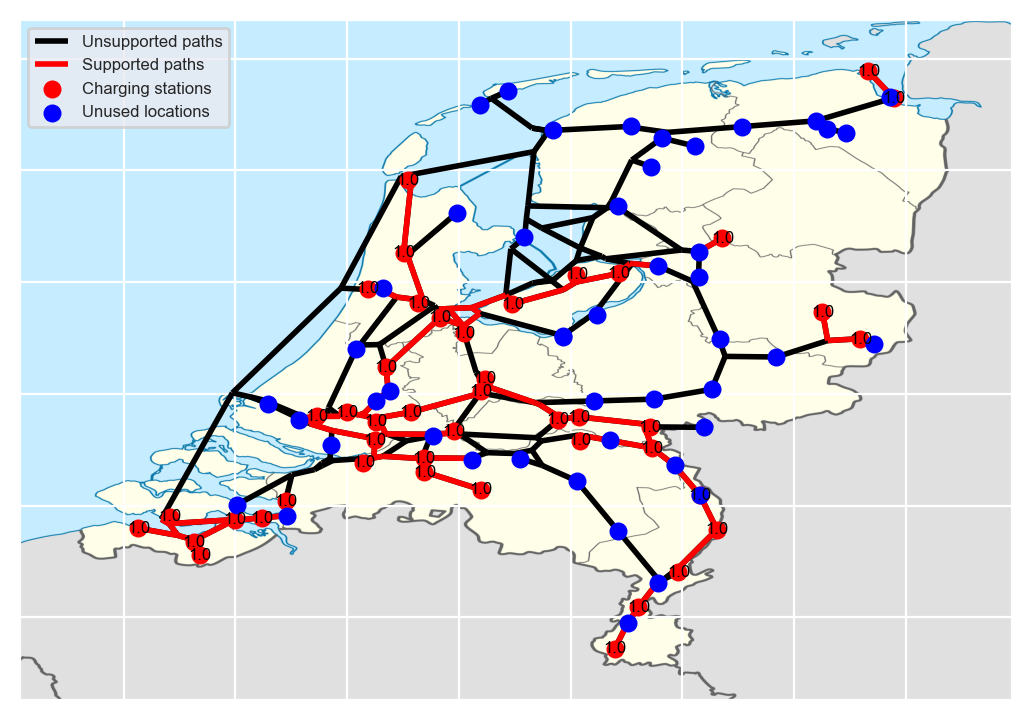

In [2]:
%%time
load=1
seed=None
r=50000
total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, add_nodes_used = flow_refueling_location_model(r,100, 2500, 5, additional_nodes=3, n=5, vis=True)

In [3]:
add_nodes_used

4.0

In [4]:
used_facilities = [i for i,j in optimal_facilities.items() if j >0]
list(set(used_facilities)-set(df_h.harbour_node.to_list()))

['103', '8867046', '8863114', '8868065']

In [2]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [3]:
# inputs
# r, p, c, x_m,  additional_nodes=0, vis=False, o=24, random_data=False, load=1, seed=None

# outputs
# total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows

In [4]:
#define parameters
model.constants = [
    Constant('p', 40),
    Constant('c', 2500),
    Constant('x_m', 5),
    Constant("random_data", False),
]

model.uncertainties = [
    # CategoricalParameter("r", [50000, 100000, 150000]),
    CategoricalParameter("r", [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000]),
#     CategoricalParameter("seed", [259572, 7542, 864199, 11540, 188813, 411862, 546078, 420812, 304196, 814030])
]

# set levers
model.levers = [
    CategoricalParameter("n", [10, 15, 20, 25]),
    CategoricalParameter("additional_nodes", [0, 1, 2, 3]),

]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ArrayOutcome('non_zero_flows'),
    ArrayOutcome("optimal_facilities"),
    ScalarOutcome('add_nodes_used'),
]

In [5]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments, Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=18) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=11, policies=4, uncertainty_sampling=Samplers.FF, lever_sampling=Samplers.FF)

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\ema_workbench\em_framework\evaluators.py:349: UserWarning: the number of processes cannot be more then 20
  warnings.warn(
[MainProcess/INFO] pool started with 18 workers
[MainProcess/INFO] performing 11 scenarios * 16 policies * 1 model(s) = 176 experiments
100%|██████████████████████████████████████| 176/176 [1:12:30<00:00, 24.72s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [6]:
pickle.dump( experiments, open( "results/experiments_batch_run_var_n.p", "wb" ) )
pickle.dump( outcomes, open("results/outcomes_batch_run_new_var_n.p", "wb") )

# experiments = pickle.load(open("results/experiments_batch_run606new.p", "rb"))
# outcomes = pickle.load(open("results/outcomes_batch_run606new.p", "rb"))

# Why n=25?

In [ ]:
experiments = pickle.load(open("results/experiments_batch_run_var_n.p", "rb"))
outcomes = pickle.load(open("results/outcomes_batch_run_var_n.p", "rb"))

In [7]:
df = pd.merge(experiments,pd.DataFrame(outcomes), left_index=True, right_index=True)

In [8]:
df

,r,additional_nodes,n,scenario,policy,model,total_flow,fraction_captured_total,serviceable_fraction,served_fraction,non_zero_flows,optimal_facilities,add_nodes_used
0,50000,0,10,16,0,frlm,2.941841e+06,0.080884,0.081129,0.996978,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
1,60000,0,10,17,0,frlm,2.941841e+06,0.090545,0.091274,0.992021,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
2,70000,0,10,18,0,frlm,2.941841e+06,0.103037,0.103069,0.999685,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
3,80000,0,10,19,0,frlm,2.941841e+06,0.219629,0.219942,0.998577,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
4,90000,0,10,20,0,frlm,2.941841e+06,0.238536,0.240058,0.993662,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,110000,3,25,22,15,frlm,2.941841e+06,0.757453,0.967891,0.782581,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
172,120000,3,25,23,15,frlm,2.941841e+06,0.788310,0.979399,0.804892,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
173,130000,3,25,24,15,frlm,2.941841e+06,0.800009,0.979399,0.816837,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
174,140000,3,25,25,15,frlm,2.941841e+06,0.807083,0.991757,0.813791,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",13.0


In [9]:
df = df.loc[~df.policy.isin([20, 21, 22, 23])]

In [10]:
df

,r,additional_nodes,n,scenario,policy,model,total_flow,fraction_captured_total,serviceable_fraction,served_fraction,non_zero_flows,optimal_facilities,add_nodes_used
0,50000,0,10,16,0,frlm,2.941841e+06,0.080884,0.081129,0.996978,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
1,60000,0,10,17,0,frlm,2.941841e+06,0.090545,0.091274,0.992021,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
2,70000,0,10,18,0,frlm,2.941841e+06,0.103037,0.103069,0.999685,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
3,80000,0,10,19,0,frlm,2.941841e+06,0.219629,0.219942,0.998577,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
4,90000,0,10,20,0,frlm,2.941841e+06,0.238536,0.240058,0.993662,"{'22637863': 1.0, '22638019': 1.0, '22638146':...","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,110000,3,25,22,15,frlm,2.941841e+06,0.757453,0.967891,0.782581,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
172,120000,3,25,23,15,frlm,2.941841e+06,0.788310,0.979399,0.804892,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
173,130000,3,25,24,15,frlm,2.941841e+06,0.800009,0.979399,0.816837,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",11.0
174,140000,3,25,25,15,frlm,2.941841e+06,0.807083,0.991757,0.813791,"{'101': 0.0, '102': 0.0, '103': 0.0, '104': 0....","{('NLABL', 'NLRTM', 0): {'combinations': [['88...",13.0


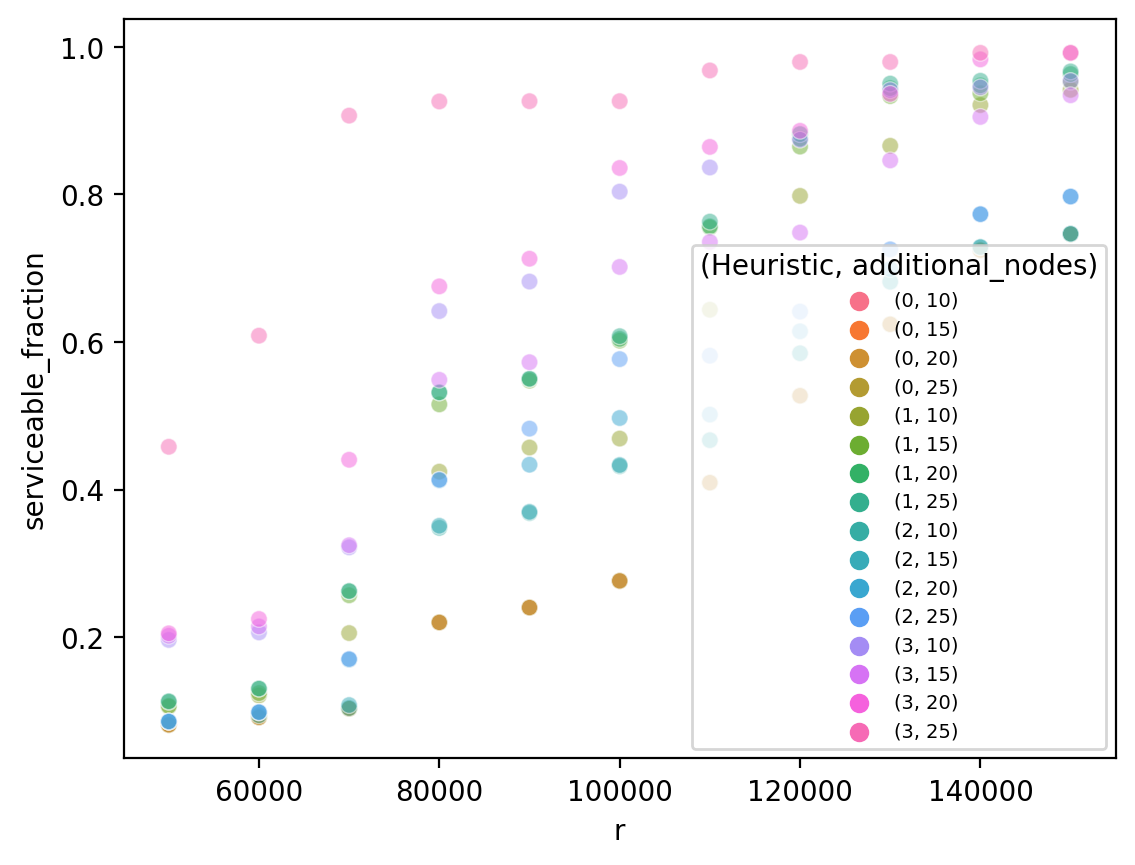

In [11]:
fig, ax = plt.subplots(dpi=200)

sns.scatterplot(x='r', y='serviceable_fraction', hue=df[['additional_nodes', 'n']].apply(tuple, axis=1), data=df, ax=ax, alpha=0.5)
ax.legend(loc='lower right', title="(Heuristic, additional_nodes)", fontsize=7)


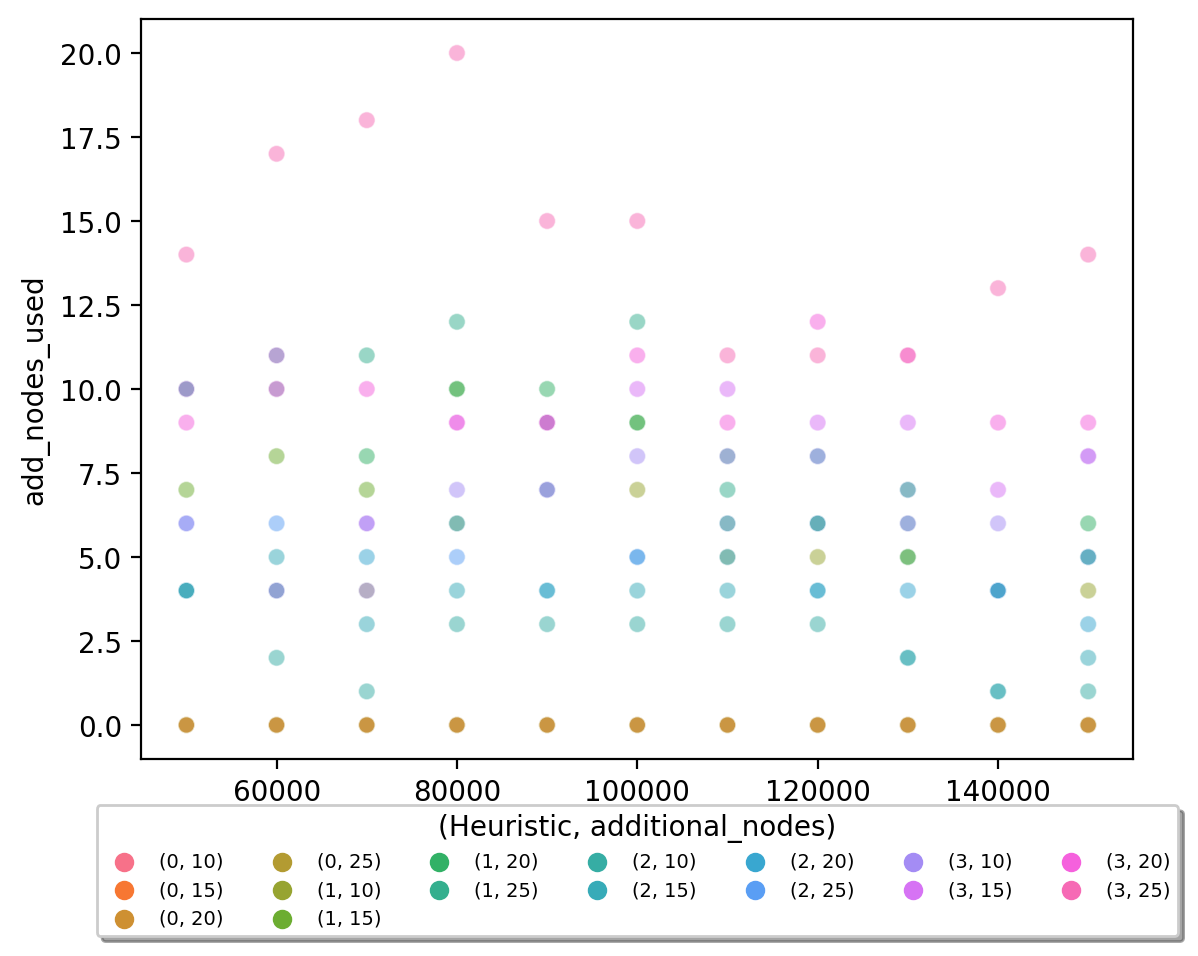

In [12]:
fig, ax = plt.subplots(dpi=200)

sns.scatterplot(x='r', y='add_nodes_used', hue=df[['additional_nodes', 'n']].apply(tuple, axis=1), data=df, ax=ax, alpha=0.5)
# ax.legend(loc='lower right', title="(Heuristic, additional_nodes)", fontsize=7)
ax.legend(title="(Heuristic, additional_nodes)", loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=7, fontsize=7)

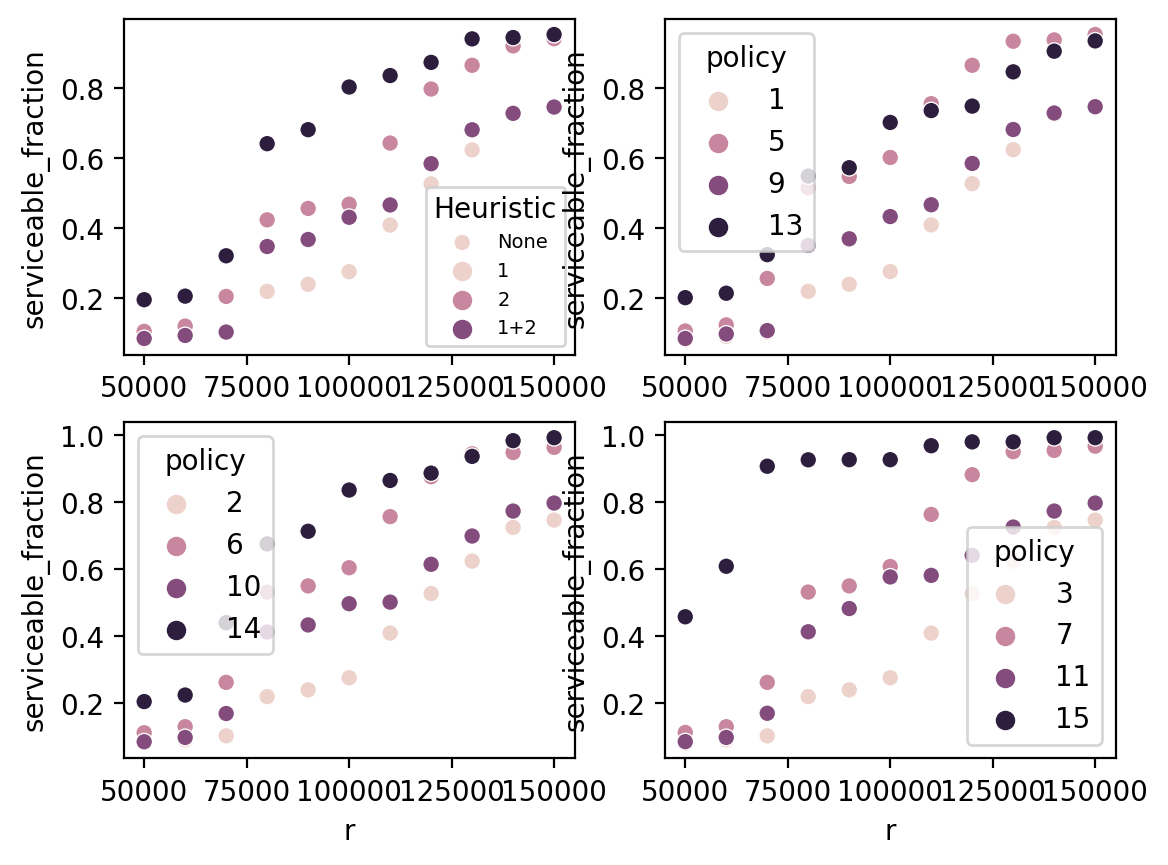

In [13]:
fig, ax = plt.subplots(2, 2, dpi=200)

sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==10)], ax=ax[0,0])
ax[0,0].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==15)], ax=ax[0,1])
# ax[0,1].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==20)], ax=ax[1,0])
# ax[1,0].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==25)], ax=ax[1,1])
# ax[1,1].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

# sns.scatterplot(x='r', y='serviceable_fraction', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==25)], ax=ax[2,0])
# ax[2,0].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# # plt.title("Serviceable fraction considering various ranges")
# # plt.ylabel("Serviceable fraction")


# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")
# plt.xlabel("Vessel range")
# plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
# plt.legend(title="Heuristic", labels=["None", "None"])
plt.show()

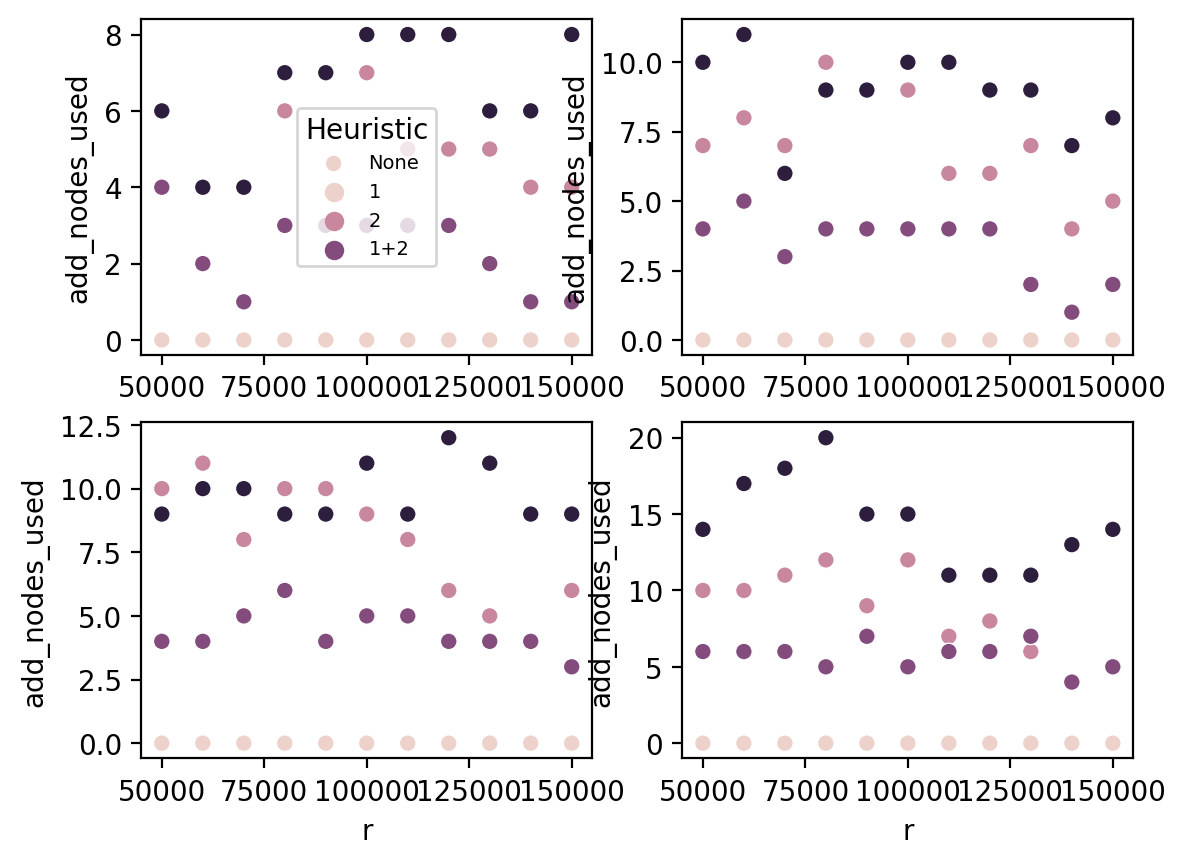

In [14]:
fig, ax = plt.subplots(2, 2, dpi=200)

sns.scatterplot(x='r', y='add_nodes_used', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==10)], ax=ax[0,0])
ax[0,0].legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='add_nodes_used', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==15)], ax=ax[0,1])
ax[0,1].legend([],[], frameon=False)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='add_nodes_used', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==20)], ax=ax[1,0])
ax[1,0].legend([],[], frameon=False)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")

sns.scatterplot(x='r', y='add_nodes_used', hue='policy', data=df.loc[((df.additional_nodes==0)&(df.n==5))|(df.n==25)], ax=ax[1,1])
ax[1,1].legend([],[], frameon=False)
# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")


# plt.title("Serviceable fraction considering various ranges")
# plt.ylabel("Serviceable fraction")
# plt.xlabel("Vessel range")
# plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"])
# plt.legend(title="Heuristic", labels=["None", "None"])
plt.show()

# Performance heuristics n=25

In [24]:
experiments = pickle.load(open("results/experiments_batch_run_n_25.p", "rb"))
outcomes = pickle.load(open("results/outcomes_batch_run_n_25.p", "rb"))

In [25]:
df = pd.merge(experiments,pd.DataFrame(outcomes), left_index=True, right_index=True)

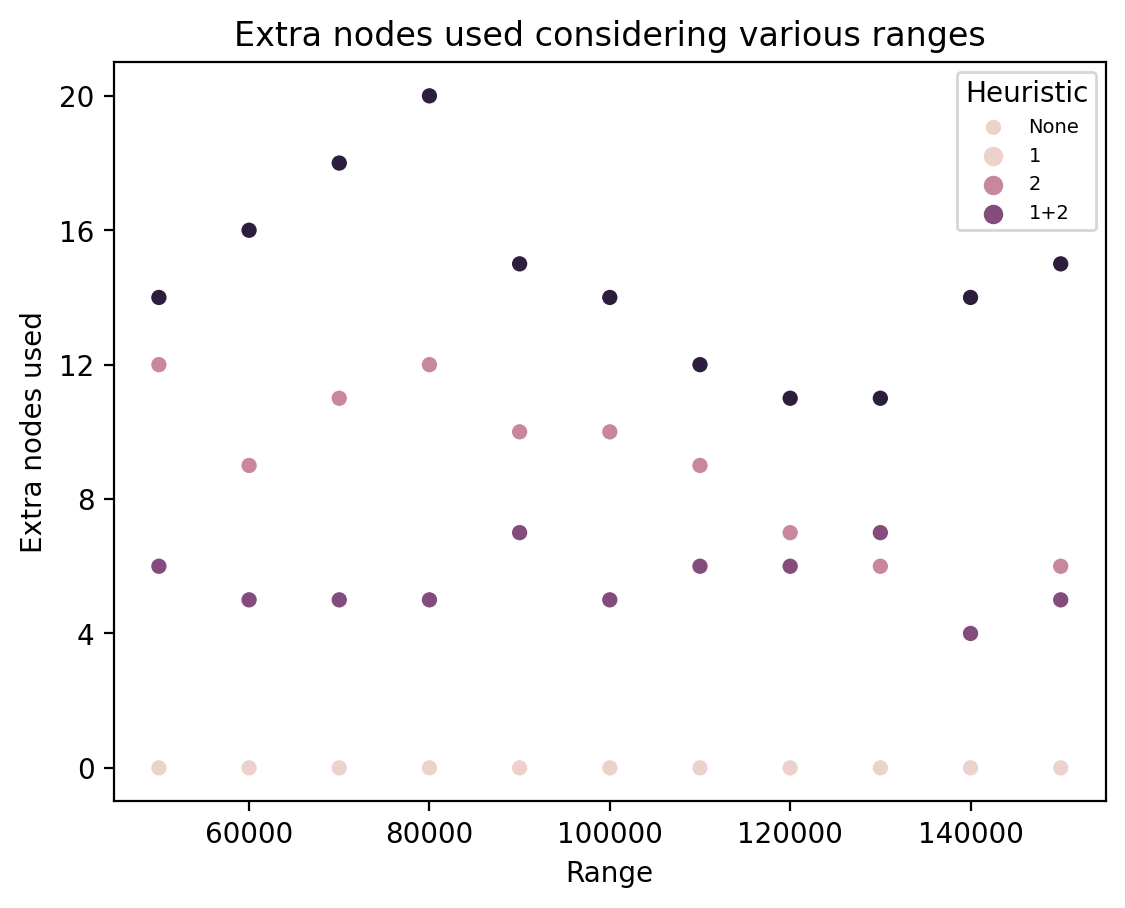

(None,)

In [26]:
fig, ax = plt.subplots(dpi=200)
sns.scatterplot(x='r', y='add_nodes_used', hue='additional_nodes', data=df, ax=ax)
plt.title("Extra nodes used considering various ranges")
plt.ylabel("Extra nodes used")
plt.yticks(np.arange(0, 21, 4))
plt.xlabel("Range")
plt.legend(title="Heuristic", labels=["None", "1", "2", "1+2"], fontsize=7)
plt.show(),

Text(0.5, 1.0, 'Fraction captured total considering various ranges')

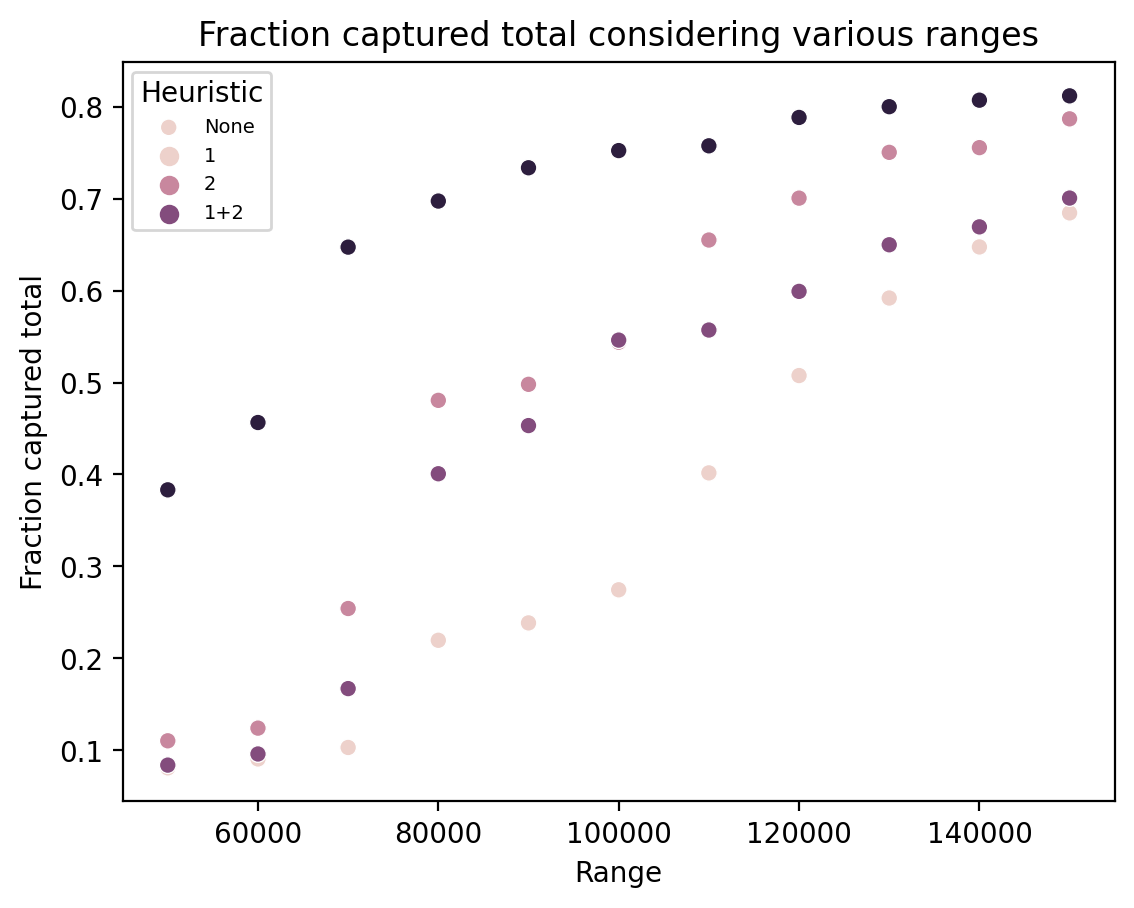

In [37]:
plt.subplots(dpi=200)
sns.scatterplot(x='r', y='fraction_captured_total', hue='additional_nodes', data=df)
plt.legend(title="Heuristic", labels= ["None", "1", "2", "1+2"], fontsize=7)
plt.ylabel('Fraction captured total')
plt.xlabel('Range')
plt.title('Fraction captured total considering various ranges')

Text(0.5, 0, 'Range')

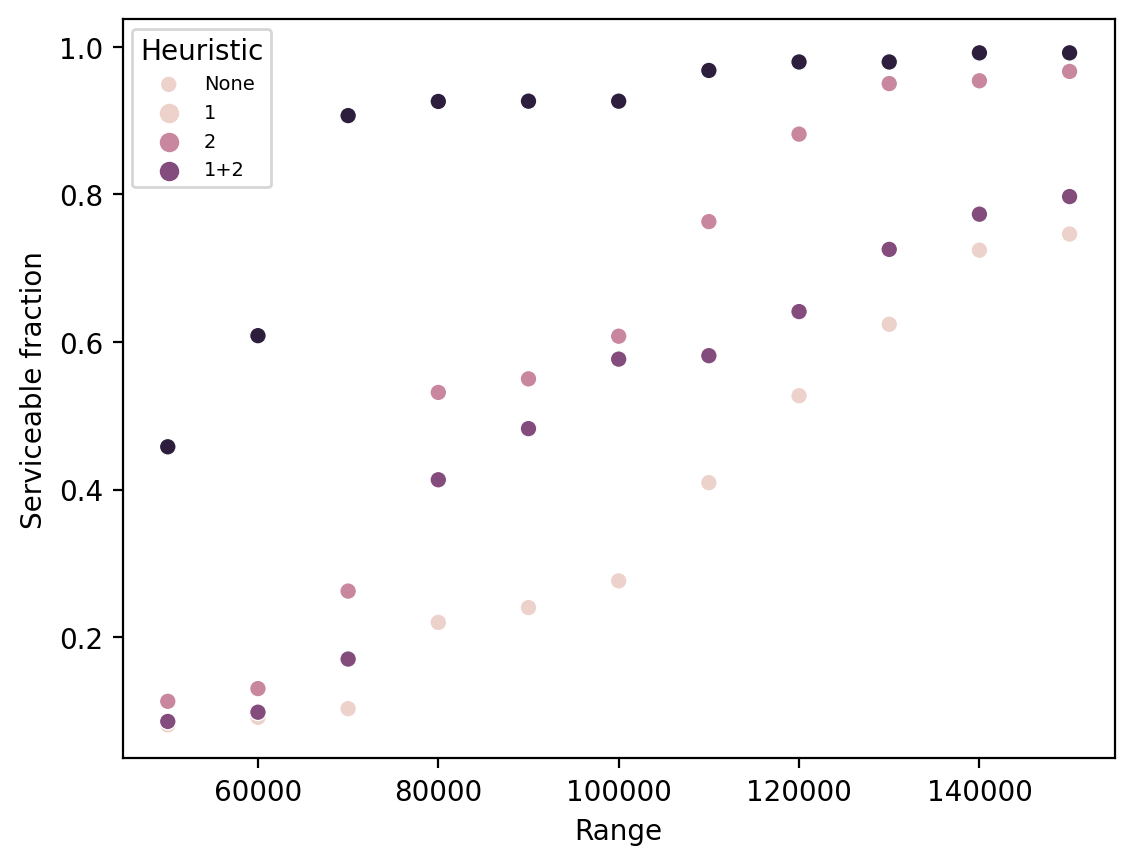

In [35]:
plt.subplots(dpi=200)
sns.scatterplot(x='r', y='serviceable_fraction', hue='additional_nodes', data=df)
plt.legend(title="Heuristic",  labels=["None", "1", "2", "1+2"], fontsize=7)
plt.ylabel('Serviceable fraction')
plt.xlabel('Range')